## Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import os

## Creating Required Directories

In [2]:
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)

## Dataset Loading

In [3]:
def load_and_prepare_data(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath, parse_dates=['Date'])
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

filepaths = {
    "NVDA": "data/NVDA_2005_2023.csv",
    "QQQ": "data/QQQ_2005_2023.csv",
    "SOXS": "data/SOXS_2005_2023.csv"
}

datasets = {name: load_and_prepare_data(path) for name, path in filepaths.items()}

## Calculating Volatility

In [4]:
def compute_volatility(df: pd.DataFrame) -> pd.DataFrame:
    df['Volatility'] = (df['High'] - df['Low']) / df['Close']
    df['Volume_delta'] = df['Volume'].diff()
    df['Volatility_delta'] = df['Volatility'].diff()
    df.dropna(inplace=True)
    return df[['Date', 'Volume_delta', 'Volatility_delta']]


## Modelling

In [5]:
def fit_linear_model(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model, model.coef_, model.intercept_

def fit_polynomial_model(X, y, degree=2):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)
    return model, poly, model.coef_, model.intercept_, r2

## Model Evaluation

In [ ]:
def evaluate_model(model, poly, X, y, name="Model"):
    X_poly = poly.transform(X)
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', alpha=0.3, label='Actual')
    plt.plot(X, y_pred, color='red', label='Predicted')
    plt.xlabel('Volume Delta')
    plt.ylabel('Volatility Delta')
    plt.title(f'{name} (R² = {r2:.4f})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots/{name}_fit.png")
    plt.show()

    from IPython.display import Image, display
    display(Image(filename=f"plots/{name}_fit.png"))

    return r2

## Saving The Equations and Visualizing the results


===== Analyzing NVDA =====
Linear Model: R² = 0.2875, Coef = [3.87176928e-10], Intercept = -2.457425946479338e-07
NVDA Polynomial Model:
ΔV = -1.75e-19*(ΔVolume)^2 + 3.89e-10*(ΔVolume) + 0.00013
R² = 0.2883
-----------------------------



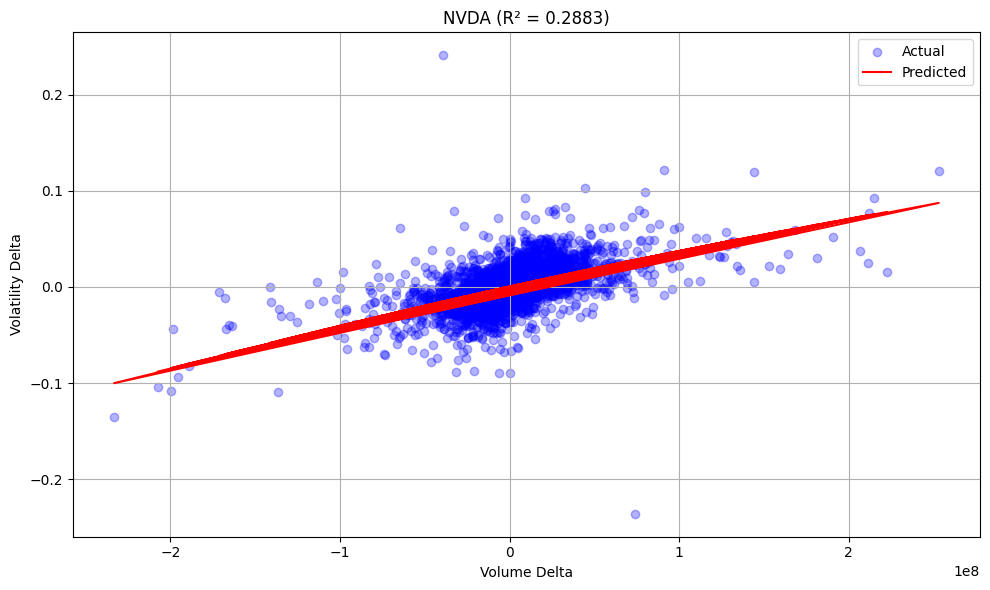

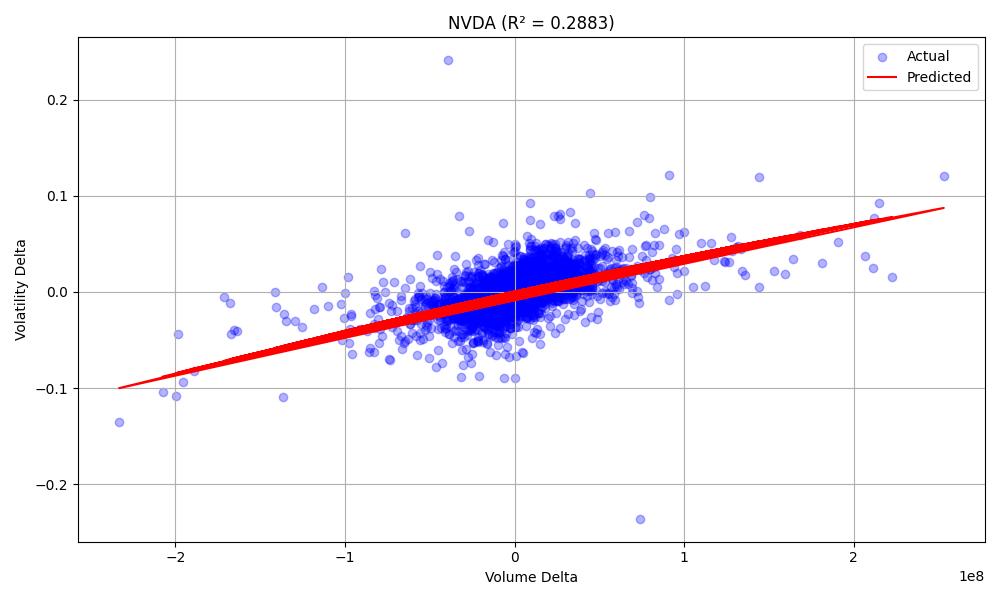


===== Analyzing QQQ =====
Linear Model: R² = 0.2753, Coef = [1.72533481e-10], Intercept = -6.928668565502883e-07
QQQ Polynomial Model:
ΔV = -1.31e-19*(ΔVolume)^2 + 1.76e-10*(ΔVolume) + 0.00009
R² = 0.2783
-----------------------------



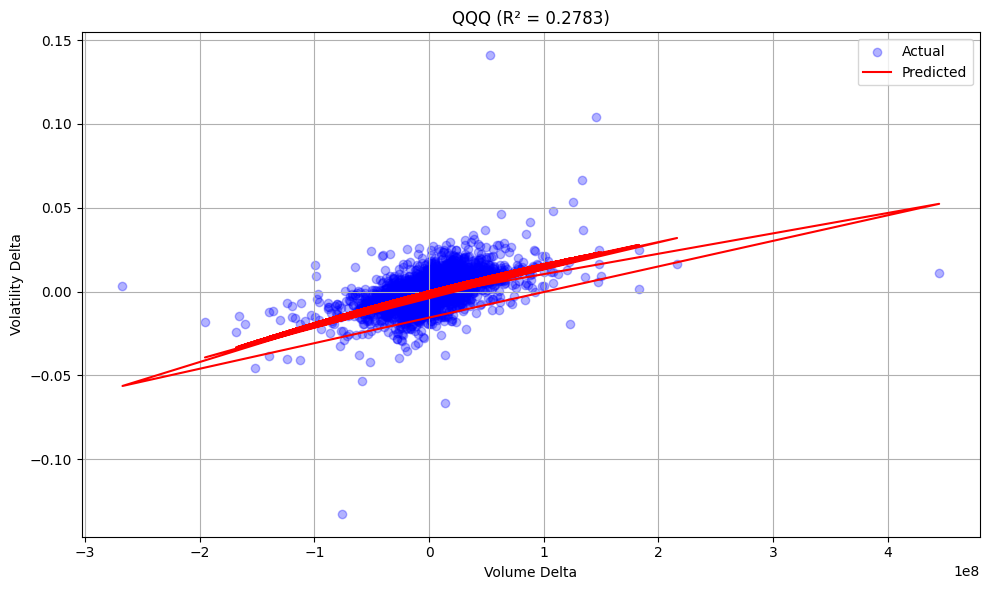

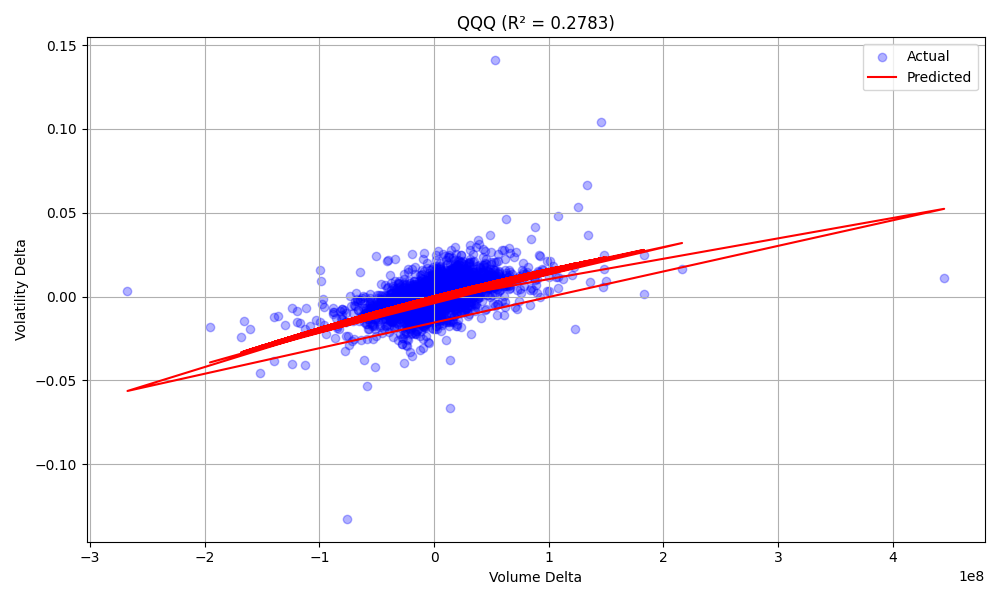


===== Analyzing SOXS =====
Linear Model: R² = 0.0509, Coef = [1.63983348e-09], Intercept = -2.816854540307223e-05
SOXS Polynomial Model:
ΔV = 3.16e-18*(ΔVolume)^2 + 1.64e-09*(ΔVolume) + -0.00010
R² = 0.0511
-----------------------------



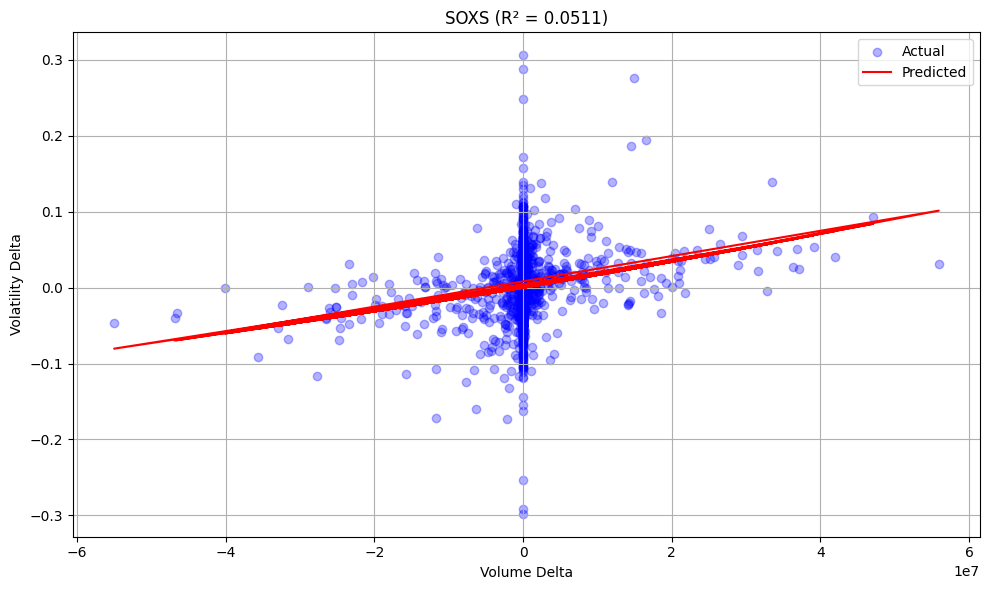

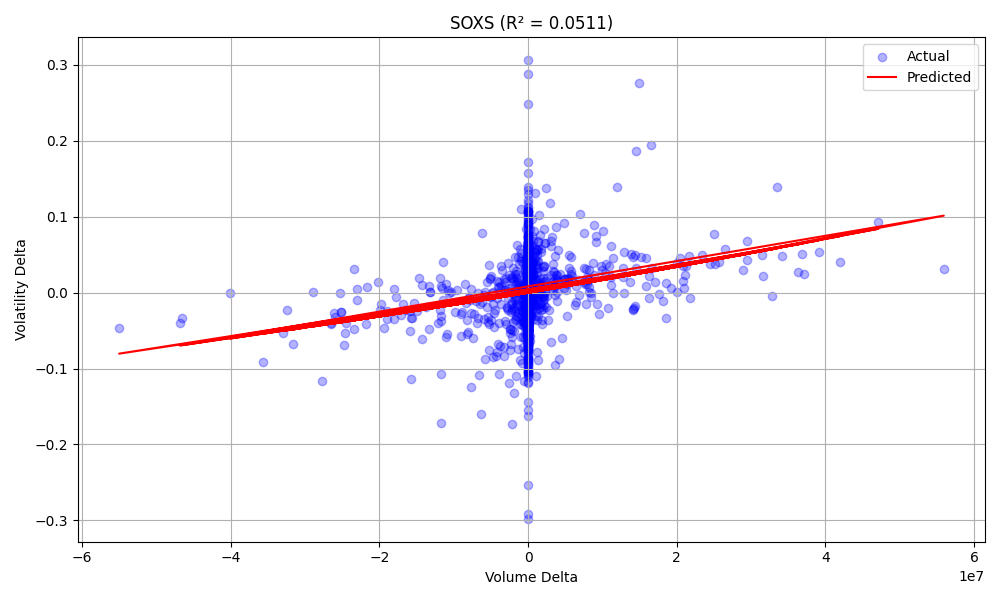

In [ ]:
with open("results/model_equations.txt", "w") as f:
    for name, df in datasets.items():
        print(f"\n===== Analyzing {name} =====")
        features = compute_volatility(df)
        X = features['Volume_delta'].values.reshape(-1, 1)
        y = features['Volatility_delta'].values

        lin_model, coef, intercept = fit_linear_model(X, y)
        y_pred_lin = lin_model.predict(X)
        r2_lin = r2_score(y, y_pred_lin)
        print(f"Linear Model: R² = {r2_lin:.4f}, Coef = {coef}, Intercept = {intercept}")

        poly_model, poly, coefs, intercept, r2_poly = fit_polynomial_model(X, y)
        eqn = (
            f"{name} Polynomial Model:\n"
            f"ΔV = {coefs[2]:.2e}*(ΔVolume)^2 + {coefs[1]:.2e}*(ΔVolume) + {intercept:.5f}\n"
            f"R² = {r2_poly:.4f}\n"
            "-----------------------------\n"
        )
        print(eqn)
        f.write(eqn)

        evaluate_model(poly_model, poly, X, y, name=name)
